#### Load required modules

In [36]:
from scipy.optimize import differential_evolution
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from datetime import datetime
import json
from pathlib import Path
import os
import emcee
import pandas as pd

from gpr_modelling.forward.data import load_and_split_data, split_data, normalize_data
from gpr_modelling.forward.utils import load_scalers, load_gpr_models, evaluate_gp
from gpr_modelling.forward.config import MODEL_DIR, SCALER_DIR, PROCESSED_DATA_DIR, INVERSE_RESULTS_DIR

### Load required objects

In [3]:
# Data loading and processing
q_data, y_data, y_cols = load_and_split_data(path = PROCESSED_DATA_DIR/"datasets.xlsx")
q1, q2, y1, y2 = split_data(q_data, y_data)
X_train, X_test, y_train, y_test, q_scaler, y_scaler = normalize_data(q1, q2, y1, y2)

# Load pre-trained Gaussian Process Regression (GPR) models and scalers
gpr_models = load_gpr_models(MODEL_DIR)
q_scaler, y_scaler = load_scalers(SCALER_DIR)

### Approach 1: point estimate with differential evolution

#### Approach 1.1.: differential evolution with callback + 1 run

In [ ]:
# ----- Simulate noisy observation -----
NOISE_STD = 0.05 
y_clean = y2[-1]  # True clean observation (used only to create noisy data)
noise = np.random.normal(0, NOISE_STD, size=y_clean.shape)
y_obs = y_clean + noise  # Simulated observed sample with noise

true_q = q2[-1] 

# ----- Define the loss function -----
def loss_function1(q, gpr_models, y_obs, q_scaler, y_scaler):
    q = np.array(q).reshape(1, -1)  # Ensure 2D shape
    q_scaled = q_scaler.transform(q)

    # Predict using the GPR models (output is still scaled)
    y_pred_scaled = np.array([
        gpr_models[feature].predict(q_scaled)[0]
        for feature in gpr_models.keys()
    ]).reshape(1, -1)

    # Inverse-transform the prediction to original scale
    y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()

    # Compute loss: Mean Squared Error
    return np.mean((y_pred - y_obs) ** 2)

# Loss tracking
loss_trace = []

def callback_func(xk, convergence):
    """Callback to track loss during optimization."""
    loss = loss_function1(xk, gpr_models, y_obs, q_scaler, y_scaler)
    loss_trace.append(loss)


# ----- Define bounds for differential evolution -----
# For each q_i ∈ [lb, ub]
lb = 0.1
ub = 5.0
bounds = [(lb, ub)] * 4  # 4 parameters

# ----- Run optimization -----
result = differential_evolution(
    loss_function1,
    bounds=bounds,
    args=(gpr_models, y_obs, q_scaler, y_scaler),  # y_obs = y_test[-1]
    strategy="best1bin",
    mutation=(0.5, 1.5),
    callback=callback_func,
    maxiter=1000,
    popsize=15,
    tol=0.01,
    disp=False,
    polish=True
)

# ----- Extract and report results -----
point_estimate_q = result.x
final_loss = result.fun

print("Best-fit parameters (point estimate):", point_estimate_q)
print("Final MSE loss:", final_loss)
print("True values:", true_q)
print("Absolute error:", np.abs(point_estimate_q - true_q))

# ----- Save results -----
results = {
    "point_estimate_q": point_estimate_q.tolist(),
    "true_q": true_q.tolist(),
    "final_loss": float(final_loss),
    "abs_error": np.abs(point_estimate_q - true_q).tolist(),
    "y_obs": y_obs.tolist(),
    "loss_trace": loss_trace
}

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"single_DE_inference_results_{timestamp}.json"

with open(INVERSE_RESULTS_DIR / filename, "w") as f:
    json.dump(results, f, indent=4)


Best-fit parameters (point estimate): [4.52118846 3.56180273 1.98500063 4.25568909]
Final MSE loss: 0.00023962317338052858
True values: [4.5003191  3.58852013 3.89245368 3.50792196]
Absolute error: [0.02086936 0.0267174  1.90745305 0.74776713]


##### Trace Plot

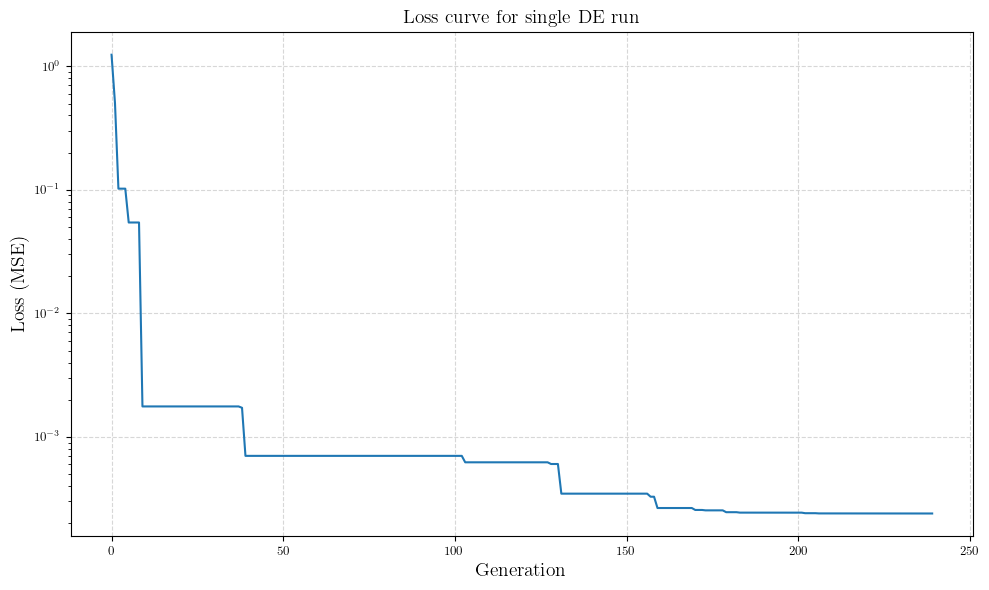

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(loss_trace, linestyle='-')
plt.xlabel("Generation", fontsize=14)
plt.ylabel("Loss (MSE)", fontsize=14)
plt.yscale("log")
plt.title(f"Loss curve for single DE run", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(INVERSE_RESULTS_DIR / f"single_DE_loss_curve.pdf")
plt.show()

#### Approach 1.2.: differential evolution with random callback + 50 runs

In [7]:
# ----- Define the loss function -----
def loss_function2(q, gpr_models, y_obs, q_scaler, y_scaler):
    q = np.array(q).reshape(1, -1)  # Ensure 2D shape
    q_scaled = q_scaler.transform(q)

    # Predict using the GPR models (output is still scaled)
    y_pred_scaled = np.array([
        gpr_models[feature].predict(q_scaled)[0]
        for feature in gpr_models.keys()
    ]).reshape(1, -1)

    # Inverse-transform the prediction to original scale
    y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()

    # Compute loss: Mean Squared Error
    return np.mean((y_pred - y_obs) ** 2)

# -------- Loss tracking --------
loss_trace_all = []

def make_callback(run_idx):
    trace = []
    def callback_func(xk, convergence):
        """Callback to track loss during optimization."""
        loss = loss_function2(xk, gpr_models, y_obs, q_scaler, y_scaler)
        trace.append(loss)

    loss_trace_all.append(trace)
    return callback_func

# ----- Define bounds for differential evolution -----
num_runs = 50
all_estimates = []
all_losses = []
all_errors = []

true_q = q2[-1]
y_clean = y2[-1]
noise_std = 0.05


# Loop over 50 DE runs
for run in range(num_runs):
    noise = np.random.normal(0, noise_std, size=y_clean.shape)
    y_obs = y_clean + noise

    # DE optimization
    result = differential_evolution(
        loss_function2,
        bounds=[(0.1, 5.0)] * 4,
        args=(gpr_models, y_obs, q_scaler, y_scaler),
        strategy="best1bin",
        mutation=(0.5, 1.5),
        maxiter=1000,
        popsize=15,
        callback=make_callback(run),
        tol=0.01,
        disp=False,
        polish=True
    )

    q_est = result.x
    loss = result.fun
    abs_error = np.abs(q_est - true_q)

    #print(q_est)

    all_estimates.append(q_est)
    all_losses.append(loss)
    all_errors.append(abs_error)

all_estimates = np.array(all_estimates)  # shape: (50, 4)
all_errors = np.array(all_errors)        # shape: (50, 4)

# Get the best estimate *per* q_i
best_qs = []
best_indices = []

for i in range(4):
    best_idx = np.argmin(all_errors[:, i])
    best_q = all_estimates[best_idx, i]
    best_qs.append(best_q)
    best_indices.append(best_idx)

best_qs = np.array(best_qs)
point_estimate_q = best_qs.tolist()

# Report
print("Best per-component estimates:")
for i in range(4):
    print(f"q{i+1}: estimate = {best_qs[i]:.4f} (from run {best_indices[i]}) | true = {true_q[i]:.4f} | abs error = {abs(best_qs[i] - true_q[i]):.4f}")

print(f"Final inference results: {best_qs}")

Best per-component estimates:
q1: estimate = 4.5018 (from run 6) | true = 4.5003 | abs error = 0.0015
q2: estimate = 3.5894 (from run 34) | true = 3.5885 | abs error = 0.0009
q3: estimate = 3.8222 (from run 26) | true = 3.8925 | abs error = 0.0703
q4: estimate = 3.5280 (from run 13) | true = 3.5079 | abs error = 0.0201
Final inference results: [4.50179373 3.5893757  3.82218959 3.52798535]


##### Save Results

In [9]:
# ----- Save results -----
results = {
    "point_estimate_q": point_estimate_q,
    "true_q": true_q.tolist(),
    "final_loss": float(loss),
    "abs_error": np.abs(point_estimate_q - true_q).tolist(),
    "y_obs": y_obs.tolist()
}

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"50_DE_inference_results_{timestamp}.json"
de_path = INVERSE_RESULTS_DIR / filename

with open(de_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"[INFO] Results saved to {de_path}")

[INFO] Results saved to /home/amaro/gpr_modelling/results/inverse/50_DE_inference_results_20250630_182713.json


##### Trace Plot

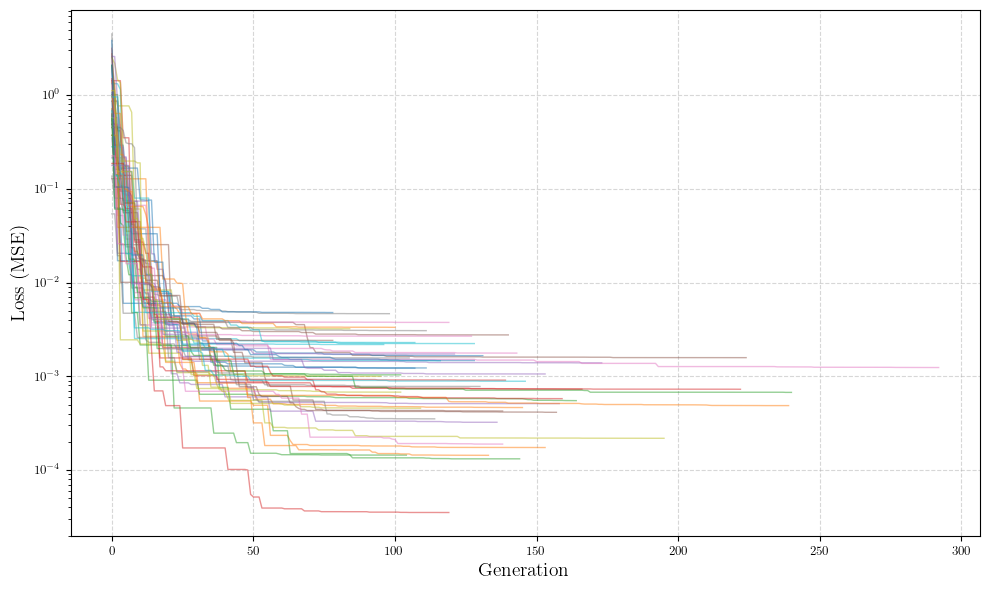

In [32]:
plt.figure(figsize=(10, 6))
for trace in loss_trace_all:
    plt.plot(trace, alpha=0.5, linewidth=1)

plt.xlabel("Generation", fontsize=14)
plt.ylabel("Loss (MSE)", fontsize=14)
plt.yscale("log")
#plt.title("Loss evolution across 50 DE runs", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(INVERSE_RESULTS_DIR / "50_DE_all_loss_curves.pdf", dpi=300)
plt.show()


##### KDE plots

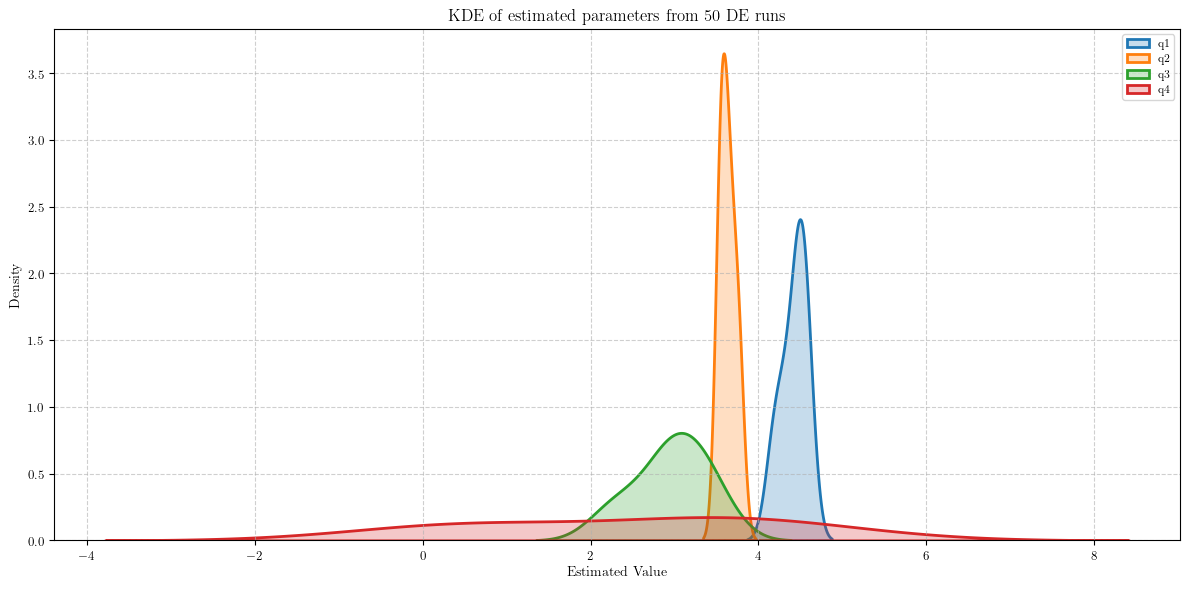

In [15]:
param_names = ['q1', 'q2', 'q3', 'q4']

plt.figure(figsize=(12, 6))
for i in range(len(param_names)):
    sns.kdeplot(all_estimates[:, i], fill=True, label=param_names[i], linewidth=2)

plt.xlabel("Estimated Value")
plt.ylabel("Density")
# plt.yscale("log")
plt.title("KDE of estimated parameters from 50 DE runs")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig(INVERSE_RESULTS_DIR / "50_DE_kde_estimates.pdf")
plt.show()

### Approach 2: MCMC with emcee library

#### Inference

In [ ]:
# ----- Simulate noisy observation -----
NOISE_STD = 0.05  # Adjust as needed
y_clean = y2[-1]  # True clean observation (used only to create noisy data)
noise = np.random.normal(0, NOISE_STD, size=y_clean.shape)
y_obs = y_clean + noise  # Simulated observed sample with noise

def log_likelihood(q, gpr_models, y_obs, q_scaler, y_scaler):
    q = q.reshape(1, -1)
    
    # Scale q to match GP input space
    q_scaled = q_scaler.transform(q)

    means, stds = evaluate_gp(gpr_models, X_test=q_scaled, y_scaler=y_scaler, return_std=True)
    means = means.flatten()
    stds_gp = stds.flatten()

    # Add the observation noise in quadrature
    # Assuming NOISE_STD is applied to each observation independently
    total_stds_squared = stds_gp**2 + NOISE_STD**2
    stds_combined = np.sqrt(total_stds_squared)
    stds_combined += 1e-6  # for numerical stability to prevent log(0) or division by 0

    residuals = y_obs - means
    # The sum here implies that y_obs is a vector and each element contributes
    # independently to the likelihood.
    log_likelihood_val = -0.5 * np.sum((residuals / stds_combined)**2 + np.log(2 * np.pi * stds_combined**2))

    return log_likelihood_val


def log_prior(q, lb, ub):
    if np.all(lb <= q) and np.all(q <= ub):
        return 0.0
    return -np.inf


def log_posterior(q, gpr_models, y_obs, lb, ub, q_scaler, y_scaler):
    lp = log_prior(q, lb, ub)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(q, gpr_models, y_obs, q_scaler, y_scaler)


# ---- Setup ----
ndim = 4  # number of latent parameters
nwalkers = 32 #32
nsteps = 50000  # pass to 50000 after testing
burnin = 5000
thin = 10


# Bounds (arrays)
lb = np.array([0.1] * ndim)
ub = np.array([5.0] * ndim)

# Initial guess for walkers
initial_best_guess = point_estimate_q
perturbation_std = (ub - lb) * 0.01
#x0 = np.random.uniform(low=lb, high=ub, size=(nwalkers, ndim))
x0 = initial_best_guess + perturbation_std * np.random.normal(0, 1, size=(nwalkers, ndim))

for i in range(nwalkers):
    x0[i] = np.clip(x0[i], lb, ub)

# ---- Run MCMC ----
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_posterior,
    args=(gpr_models, y_obs, lb, ub, q_scaler, y_scaler)
)

print(f"[INFO] Running MCMC with {nwalkers} walkers for {nsteps} steps...")
sampler.run_mcmc(x0, nsteps, progress=True)
print("[INFO] MCMC run complete.")

[INFO] Running MCMC with 32 walkers for 50000 steps...


100%|██████████| 50000/50000 [37:53:14<00:00,  2.73s/it]   

[INFO] MCMC run complete.

--- MCMC Results ---
Inferred Parameters (Mean): [4.47025563 3.59015288 2.59763986 2.77090587]
Uncertainty (Std Dev): [0.11057065 0.07630295 1.30022502 1.33478415]
True Values: [4.5003191  3.58852013 3.89245368 3.50792196]
Absolute Error (Mean vs True): [0.03006347 0.00163275 1.29481382 0.7370161 ]
Relative Error: [0.0066803  0.00045499 0.3326472  0.21010048]

[INFO] Results saved to /home/amaro/gpr_modelling/results/inverse/mcmc_test_results_20250702_171707.json


#### Save Samples

In [29]:
# Retrieve samples
samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)

# Define the specific path
samples_path = os.path.join(INVERSE_RESULTS_DIR, f"50k_samples.npy")

# Save the array
np.save(samples_path, samples)

print(f"Array saved to: {samples_path}")

Array saved to: /home/amaro/gpr_modelling/results/inverse/50k_samples.npy


#### Load Samples

In [37]:
# Reconstruct the exact path to the saved file
samples_path = os.path.join(INVERSE_RESULTS_DIR, f"50k_samples.npy")

# Load the array
samples = np.load(samples_path)

# You can then check its shape and content to verify it loaded correctly
print(f"Array loaded from: {samples_path}")
print(f"Shape of loaded array: {samples.shape}")
print(f"First 5 rows of loaded array:\n{samples[:5]}")

Array loaded from: /home/amaro/gpr_modelling/results/inverse/50k_samples.npy
Shape of loaded array: (144000, 4)
First 5 rows of loaded array:
[[4.44754689 3.60555662 0.64434675 2.06771427]
 [4.68111098 3.46062719 4.98760276 3.33532703]
 [4.49820214 3.57533825 4.75046326 2.23116931]
 [4.30880804 3.68408955 1.28459835 1.25636195]
 [4.49820643 3.56757073 1.91563608 1.6469331 ]]


#### Sampler Processing

In [ ]:
if samples.shape[0] > 0:
    inferred_params_mean = np.mean(samples, axis=0)
    inferred_params_std = np.std(samples, axis=0)

    # true_q is assumed to be available from the simulation setup
    # true_q = q2[-1] # This line was moved to the placeholder section for clarity
    abs_errors = np.abs(inferred_params_mean - true_q)

    print("\n--- MCMC Results ---")
    print("Inferred Parameters (Mean):", inferred_params_mean)
    print("Uncertainty (Std Dev):", inferred_params_std)
    print("True Values:", true_q)
    print("Absolute Error (Mean vs True):", abs_errors)
    # Also print relative error for context
    print("Relative Error:", abs_errors / true_q)

    # ---- Save results to JSON ----
    results = {
        "inferred_params_mean": inferred_params_mean.tolist(),
        "inferred_params_std": inferred_params_std.tolist(),
        "true_q": true_q.tolist(),
        "abs_errors": abs_errors.tolist(),
        "y_obs": y_obs.tolist(),
        "noise_std": NOISE_STD,
        "nwalkers": nwalkers,
        "nsteps": nsteps,
        "burnin": burnin,
        "thin": thin,
        "ndim": ndim
    }

    # Save to file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    json_path = os.path.join(INVERSE_RESULTS_DIR, f"mcmc_test_results_{timestamp}.json")

    with open(json_path, "w") as f:
        json.dump(results, f, indent=4)

    print(f"\n[INFO] Results saved to {json_path}")


--- MCMC Results ---
Inferred Parameters (Mean): [4.47013007 3.59022875 2.59102733 2.7614718 ]
Uncertainty (Std Dev): [0.11118693 0.07671863 1.30010646 1.33613623]
True Values: [4.5003191  3.58852013 3.89245368 3.50792196]
Absolute Error (Mean vs True): [0.03018903 0.00170862 1.30142635 0.74645016]
Relative Error: [0.0067082  0.00047614 0.33434601 0.21278984]

[INFO] Results saved to /home/amaro/gpr_modelling/results/inverse/mcmc_test_results_20250702_175418.json


#### Plot

--- Posterior Analysis ---
$q_1$: True = 4.500, Mean = 4.470, MAP = 4.493, 95% CI = [4.226, 4.688] - Inside 95% CI
$q_2$: True = 3.589, Mean = 3.590, MAP = 3.580, 95% CI = [3.442, 3.755] - Inside 95% CI
$q_3$: True = 3.892, Mean = 2.591, MAP = 3.864, 95% CI = [0.409, 4.782] - Inside 95% CI
$q_4$: True = 3.508, Mean = 2.761, MAP = 4.493, 95% CI = [0.426, 4.866] - Inside 95% CI

[INFO] Posterior plot saved to /home/amaro/gpr_modelling/results/inverse/mcmc_posterior.pdf


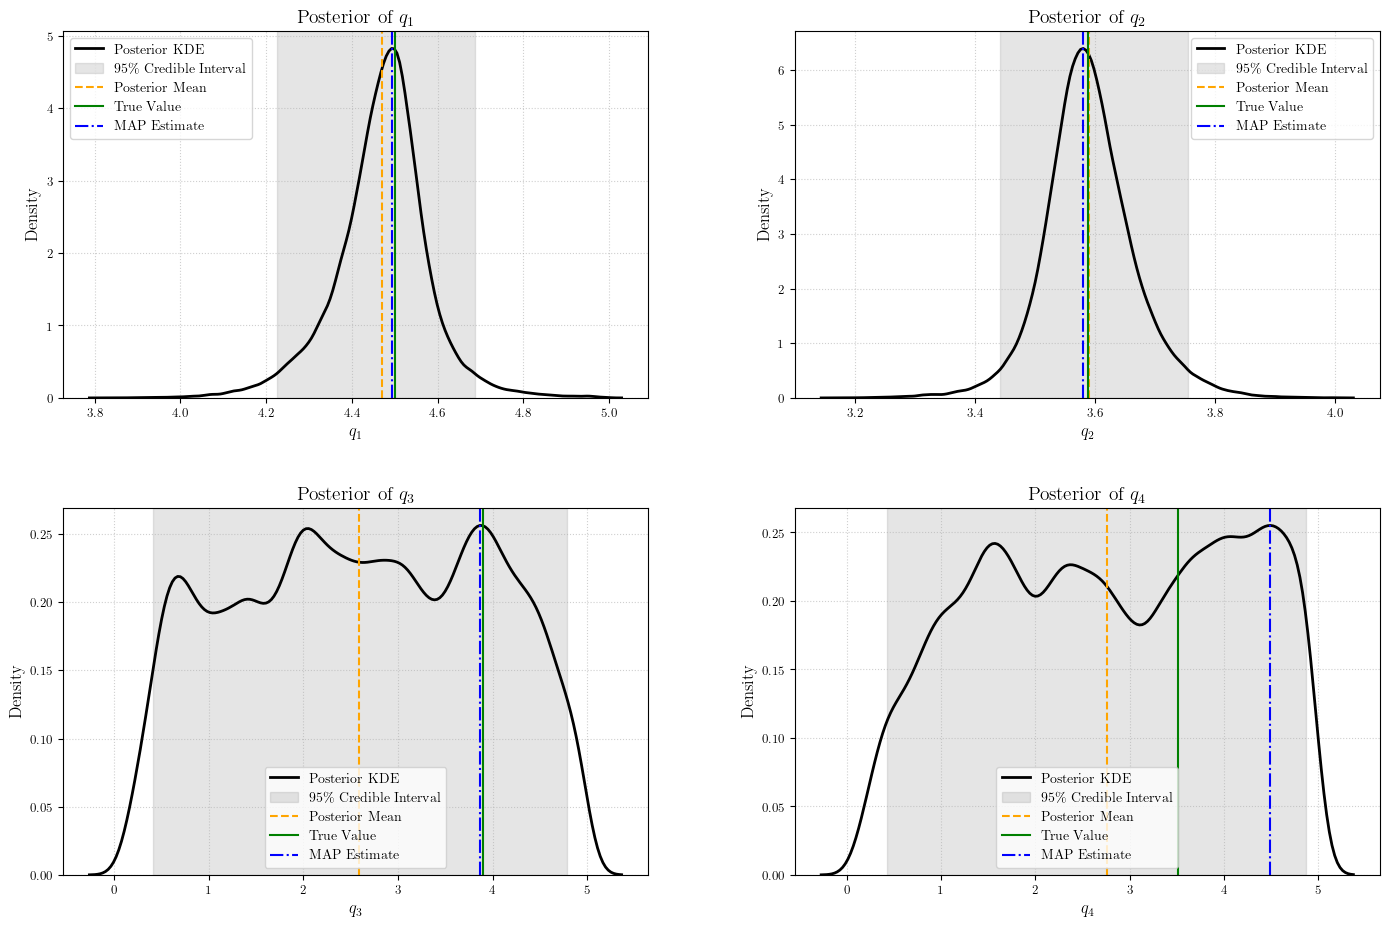

In [31]:
# Labels for plotting
param_labels = [f"$q_{i+1}$" for i in range(ndim)]
true_params = true_q # Using the defined variable for clarity

# Create the figure and axes for the subplots
# Use `ndim` directly from your setup to ensure the plot size is correct.
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14, 10)) # Adjust figsize for better layout
axes = axes.flatten() # Flatten the 2x2 grid into a 1D array of axes

print("--- Posterior Analysis ---")

for i in range(ndim):
    # Retrieve the flattened samples for the current parameter
    param_samples = samples[:, i]
    
    # Get the mean and standard deviation from the MCMC analysis results
    mean = inferred_params_mean[i]
    std = inferred_params_std[i]

    # --- CHANGE: Calculate the 95% Bayesian Credible Interval (CI) using percentiles ---
    # This is the correct approach for a Bayesian credible interval.
    ci_lower = np.percentile(param_samples, 2.5)
    ci_upper = np.percentile(param_samples, 97.5)
    
    # Get the true value for comparison
    true_val = true_params[i]
    
    # Get the current axis
    ax = axes[i]
    
    # --- CHANGE: Plot the main KDE of all samples in one call ---
    # This avoids redundant plotting and simplifies the code.
    kde_plot = sns.kdeplot(param_samples, ax=ax, color="black", linewidth=2, label="Posterior KDE")

    # --- CHANGE: Calculate MAP estimate from the plotted KDE's data ---
    # This part of your original code is a good method.
    kde_data = kde_plot.get_lines()[0].get_data()
    map_estimate = kde_data[0][np.argmax(kde_data[1])]

    # --- Plotting the intervals and lines ---
    # Fill the 95% credible interval
    ax.axvspan(ci_lower, ci_upper, color='gray', alpha=0.2, label=r"95\% Credible Interval")

    # Vertical lines for mean and true value
    ax.axvline(mean, color='orange', linestyle='--', label="Posterior Mean")
    ax.axvline(true_val, color='green', linestyle='-', label="True Value")

    # Plot the MAP estimate
    ax.axvline(map_estimate, color='blue', linestyle='-.', label="MAP Estimate")

    # --- Labels and formatting ---
    ax.set_title(f"Posterior of {param_labels[i]}", fontsize=14)
    ax.set_xlabel(f"{param_labels[i]}", fontsize=12)
    ax.set_ylabel(r"Density", fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.6) # Added linestyle for better visibility
    ax.legend(fontsize=10)

    # --- Print information and check if true value is within the CI ---
    if true_val < ci_lower or true_val > ci_upper:
        status = "Outside 95% CI"
        # ax.axvline(true_val, color='red', linestyle='-', label=r"True Value") # Optional: change color for emphasis
    else:
        status = "Inside 95% CI"
        
    print(f"{param_labels[i]}: True = {true_val:.3f}, Mean = {mean:.3f}, MAP = {map_estimate:.3f}, 95% CI = [{ci_lower:.3f}, {ci_upper:.3f}] - {status}")

# Final plot adjustments
plt.tight_layout()
# You can set a super title if you want, but tight_layout works well
#plt.suptitle(r"Posterior Distributions of Parameters with 95\% Credible Intervals", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.9, wspace=0.25, hspace=0.3) # Adjust layout for title and padding

# Save the figure
pdf_path = INVERSE_RESULTS_DIR / "mcmc_posterior.pdf"
plt.savefig(pdf_path, bbox_inches='tight') # Use bbox_inches='tight' for clean save
print(f"\n[INFO] Posterior plot saved to {pdf_path}")
plt.show()

#### Corner


[INFO] Corner plot saved to /home/amaro/gpr_modelling/results/inverse/mcmc_posterior_corner_20250702_181619.pdf


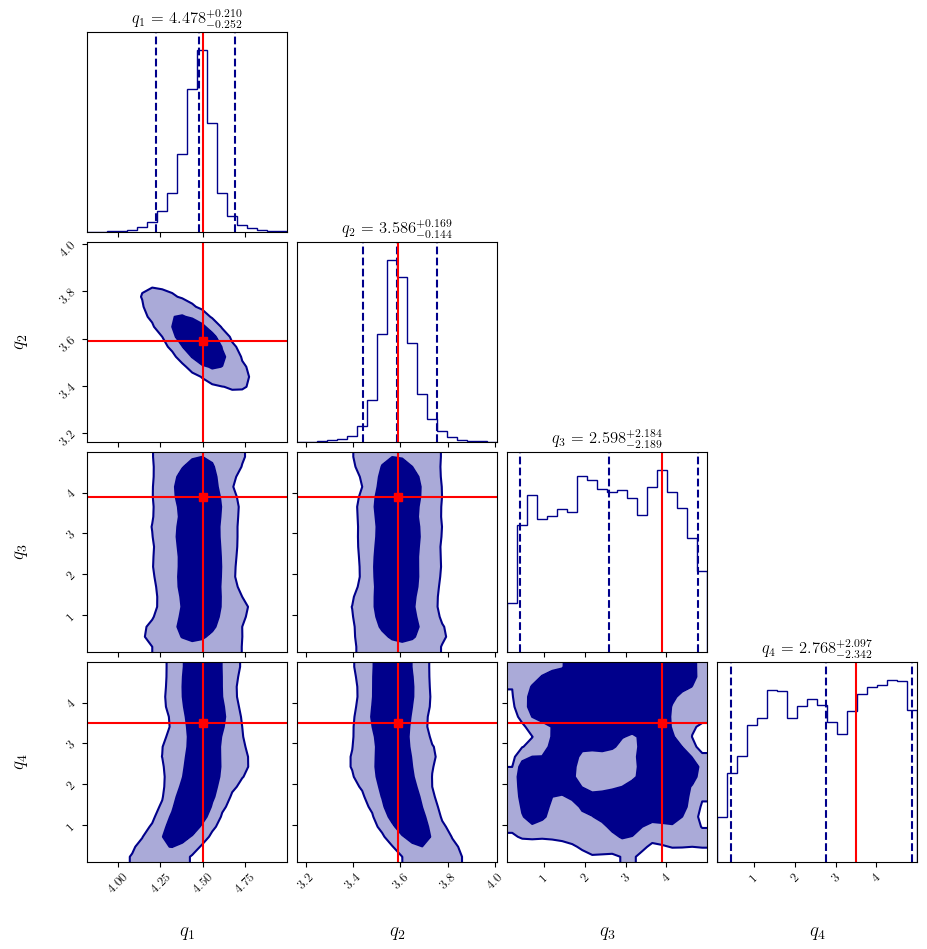

In [40]:
import corner # You might need to install this: pip install corner

# --- Dummy Data for Demonstration (Same as above) ---
ndim = 4
np.random.seed(42)
true_q = q2[-1]



# --- Labels and True Values ---
param_labels = [f"$q_{i+1}$" for i in range(ndim)]
true_params = true_q

# --- Create the corner plot ---
fig = corner.corner(
    samples,
    labels=param_labels,
    truths=true_params, # Plot true values as lines
    quantiles=[0.025, 0.5, 0.975], # Plot 95% credible intervals
    show_titles=True,
    title_fmt=".3f", # Format titles for mean/MAP estimates
    title_kwargs={"fontsize": 12},
    smooth=0.9, # Smooth the KDEs
    plot_datapoints=False, # Don't plot individual points on 2D plots
    plot_density=True,
    plot_contours=True,
    fill_contours=True,
    #hist_kwargs={'density': True}, # Ensure histograms are normalized
    levels=[0.68, 0.95], # Plot 1-sigma and 2-sigma contours (approx 68% and 95%)
    color="darkblue",
    truth_color="red", # Color for true values
    label_kwargs={"fontsize": 14},
    # The range for each parameter (optional, but good for focusing the plot)
    # range=[(0.3, 0.7), (1.8, 2.2), (-1.2, -0.8), (9.8, 10.2)] # Example range
)

# You can add a super title to the corner plot if desired
#fig.suptitle("Posterior Distributions and Correlations", fontsize=20, y=1.0)

# Save the figure
pdf_path_corner = os.path.join(INVERSE_RESULTS_DIR, f"mcmc_posterior_corner_{timestamp}.pdf")
plt.savefig(pdf_path_corner, bbox_inches='tight')
print(f"\n[INFO] Corner plot saved to {pdf_path_corner}")
plt.show()

#### TESTS

--- Posterior Analysis ---

[INFO] Posterior plot saved to /home/amaro/gpr_modelling/results/inverse/TEST_posterior.pdf


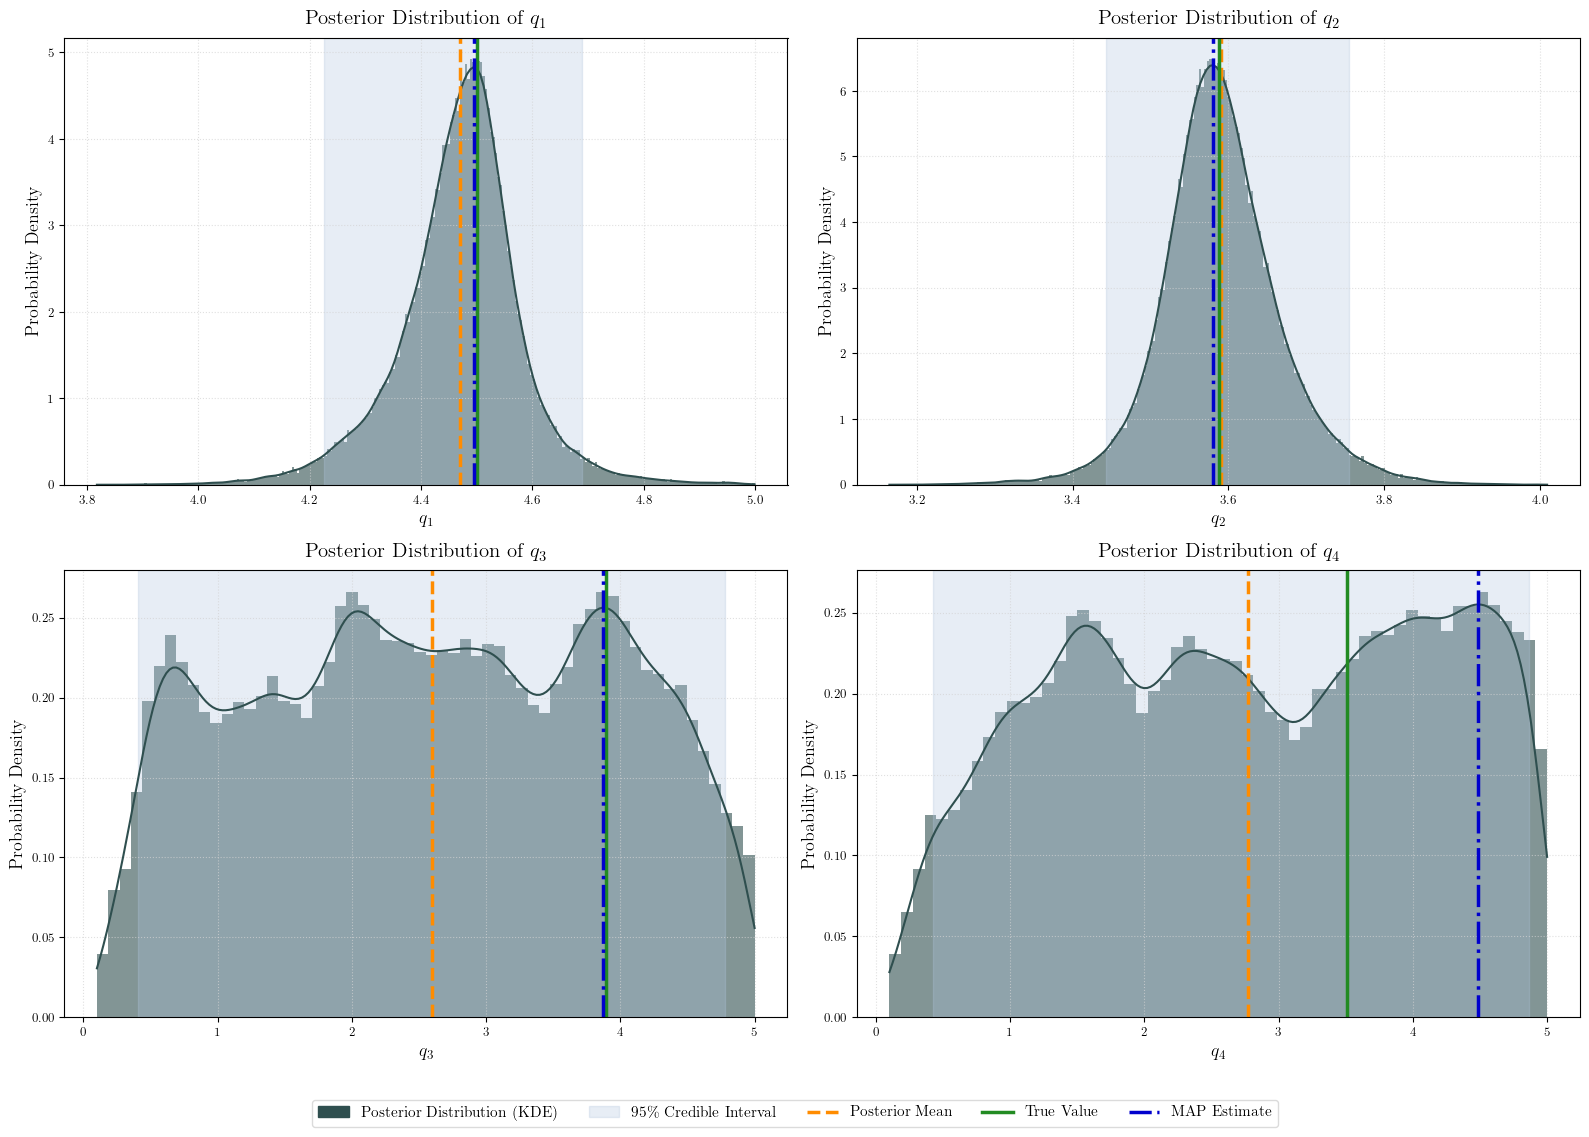

In [ ]:
# --- Dummy Data for Demonstration (Replace with your actual data) ---
# Assuming you have 'samples', 'ndim', 'true_q', 'inferred_params_mean', 'inferred_params_std'
ndim = 4
np.random.seed(42) # for reproducibility
true_q = q2[-1] # True values for the parameters

# Calculate inferred stats from the samples
inferred_params_mean = np.mean(samples, axis=0)
inferred_params_std = np.std(samples, axis=0)

# Define directory for saving (adjust this to your actual path)
# Using a relative path for demonstration; change to absolute if needed

# --- Labels for plotting ---
param_labels = [f"$q_{i+1}$" for i in range(ndim)] # Using LaTeX for q_1, q_2 etc.
true_params = true_q

# --- Create the figure and axes for the subplots ---
# Adjusted figsize for better visual balance and space for titles/annotations
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))
axes = axes.flatten() # Flatten the 2x2 grid into a 1D array of axes

# --- Define common colors/linestyles for consistency and clarity ---
posterior_color = 'darkslategray' # A more neutral, professional gray
ci_fill_color = 'lightsteelblue' # Softer, professional blue for CI
mean_color = 'darkorange'       # Warm color for the mean
map_color = 'mediumblue'        # Strong blue for the MAP
true_color = 'forestgreen'      # Green for the 'truth'
out_of_ci_true_color = 'crimson' # Red if true value is outside CI

# Define a custom legend handle for the KDE to ensure it appears correctly
from matplotlib.patches import Patch
kde_legend_handle = Patch(color=posterior_color, label='Posterior Distribution (KDE)')


for i in range(ndim):
    # Retrieve the flattened samples for the current parameter
    param_samples = samples[:, i]
    
    # Get the mean and standard deviation
    mean = inferred_params_mean[i]
    std = inferred_params_std[i]

    # Calculate the 95% Bayesian Credible Interval (CI) using percentiles
    ci_lower = np.percentile(param_samples, 2.5)
    ci_upper = np.percentile(param_samples, 97.5)
    
    # Get the true value for comparison
    true_val = true_params[i]
    
    # Get the current axis
    ax = axes[i]
    
    # --- CHANGE: Use histplot with KDE and make histogram slightly transparent ---
    # This provides the raw sample distribution alongside the smoothed KDE.
    sns.histplot(param_samples, kde=True, stat="density", ax=ax, 
                 color=posterior_color,  # Use consistent color for the hist/KDE
                 alpha=0.6, linewidth=1.5, edgecolor='none', # Remove edges for cleaner look
                 label='_nolegend_') # Prevent this histplot from creating its own legend entry

    # Get KDE data for MAP estimate (from the histplot's kde line)
    # The KDE line is the second element if histplot also draws a histogram.
    # We'll use the .patches for the histogram and .lines for the KDE.
    kde_line = ax.get_lines()[0] if ax.get_lines() else None # Get the KDE line
    if kde_line:
        kde_data = kde_line.get_data()
        # Find the x-value corresponding to the maximum density (MAP)
        map_estimate = kde_data[0][np.argmax(kde_data[1])]
    else:
        map_estimate = np.nan
        print(f"Warning: Could not retrieve KDE data for {param_labels[i]}")

    # --- Plotting the intervals and lines ---
    # Fill the 95% credible interval
    ax.axvspan(ci_lower, ci_upper, color=ci_fill_color, alpha=0.3, label=r"95\% Credible Interval")

    # Vertical lines for mean, true value, and MAP
    ax.axvline(mean, color=mean_color, linestyle='--', linewidth=2.5, label="Posterior Mean")
    
    # Use different color for true value if it's outside CI
    current_true_color = true_color
    if true_val < ci_lower or true_val > ci_upper:
        current_true_color = out_of_ci_true_color # Change color if outside CI
    ax.axvline(true_val, color=current_true_color, linestyle='-', linewidth=2.5, label="True Value")
    
    ax.axvline(map_estimate, color=map_color, linestyle='-.', linewidth=2.5, label="MAP Estimate")

    # --- CHANGE: Add concise text annotations directly on the plot ---
    # This makes the numbers immediately visible without cluttering the legend
    #y_text_pos = ax.get_ylim()[1] * 0.95 # Base Y position for text
    #ax.text(mean, y_text_pos * 0.95, f'Mean: {mean:.3f}', color=mean_color, 
    #        ha='center', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
    #ax.text(map_estimate, y_text_pos * 0.85, f'MAP: {map_estimate:.3f}', color=map_color, 
    #        ha='center', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
    #ax.text(true_val, y_text_pos * 1.05, f'True: {true_val:.3f}', color=current_true_color, 
    #        ha='center', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
    
    # Optionally add CI bounds as text:
    # ax.text(ci_lower, ax.get_ylim()[1]*0.6, f'{ci_lower:.3f}', color='dimgray', ha='left', va='top', fontsize=9)
    # ax.text(ci_upper, ax.get_ylim()[1]*0.6, f'{ci_upper:.3f}', color='dimgray', ha='right', va='top', fontsize=9)


    # --- Labels and formatting ---
    # CHANGE: More descriptive title, including key stats
    ax.set_title(f"Posterior Distribution of {param_labels[i]}", fontsize=15, color='black', pad=10)
    ax.set_xlabel(f"{param_labels[i]}", fontsize=13)
    ax.set_ylabel(r"Probability Density", fontsize=13) # More formal label
    ax.grid(True, linestyle=':', alpha=0.7, color='lightgray') # Lighter grid lines
    
    # Ensure a small margin on x-axis to prevent lines from being exactly on edge
    ax.margins(x=0.05) 
    
    # --- Legend handling for individual plots ---
    # Create a unified legend for the entire figure, rather than per subplot
    # Collect legend handles and labels from the first subplot to create one common legend
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        # Ensure KDE legend is included if not already from axvspan/axvline
        handles.insert(0, kde_legend_handle) # Insert at the beginning
        labels.insert(0, 'Posterior Distribution (KDE)')


# --- Final plot adjustments ---
# Add a super title for the entire figure
#fig.suptitle(r"Marginal Posterior Distributions of Inferred Parameters", 
             #fontsize=20, y=1.03, color='dimgray', weight='bold') # Higher y, bolder

# Adjust layout before placing the single legend
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust rect to make space for suptitle and common legend

# Place a single legend for the entire figure (below the plots)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), 
           ncol=5, fontsize=11, frameon=True, edgecolor='lightgray', fancybox=True, shadow=False) # More columns for a horizontal legend

# Save the figure
pdf_path = os.path.join(INVERSE_RESULTS_DIR, f"TEST_posterior.pdf")
plt.savefig(pdf_path, bbox_inches='tight', dpi=300) # Increased DPI for better resolution
print(f"\n[INFO] Posterior plot saved to {pdf_path}")
plt.show()